In [21]:
class Config:
    name = "EDAs/Agg/EmbededLasso"

    n_splits = 5
    seed = 2022
    target = "target"

    # Colab Env
    upload_from_colab = True
    api_path = "/content/drive/MyDrive/workspace/kaggle.json"
    drive_path = "/content/drive/MyDrive/workspace/kaggle-amex"

    # Kaggle Env
    kaggle_dataset_path = None

    # Reka Env
    dir_path = '/home/abe/kaggle/kaggle-amex'

In [22]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys
import gc
import multiprocessing
import joblib
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from IPython import get_ipython
tqdm.pandas()
warnings.filterwarnings('ignore')

## Environment Settings

In [23]:
INPUT = os.path.join(Config.dir_path, 'input')
OUTPUT = os.path.join(Config.dir_path, 'output')
SUBMISSION = os.path.join(Config.dir_path, 'submissions')
OUTPUT_EXP = os.path.join(OUTPUT, Config.name)
EXP_MODEL = os.path.join(OUTPUT_EXP, "model")
EXP_FIG = os.path.join(OUTPUT_EXP, "fig")
EXP_PREDS = os.path.join(OUTPUT_EXP, "preds")

# make dirs
for d in [INPUT, SUBMISSION, EXP_MODEL, EXP_FIG, EXP_PREDS]:
    os.makedirs(d, exist_ok=True)

## Load data

In [24]:
train = pd.read_pickle(os.path.join(INPUT, 'train_agg.pkl'), compression='gzip')
test = pd.read_pickle(os.path.join(INPUT, 'test_agg.pkl'), compression='gzip')
# train = train.sample(100000)
# test = test.sample(15000)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 919 entries, P_2_mean to target
dtypes: category(2), float16(713), float64(178), int64(22), int8(4)
memory usage: 1.3 GB


In [26]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024194,0.868652,0.960449,0.934570,0.010704,0.024440,0.001082,0.091492,0.009117,...,13,O,1,0,NaN,0,13,6.0,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022097,0.861328,0.929199,0.880371,0.215210,0.199123,0.002224,0.567383,0.178101,...,13,O,1,0,NaN,0,13,6.0,1,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028837,0.797852,0.904297,0.880859,0.004181,0.002759,0.000802,0.009705,0.009705,...,13,R,1,0,NaN,0,13,6.0,1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020082,0.567383,0.623535,0.621582,0.048859,0.088490,0.000660,0.268555,0.001082,...,13,O,1,0,NaN,0,13,3.0,3,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042316,0.805176,0.940430,0.872070,0.004642,0.002883,0.000030,0.008682,0.005573,...,13,O,1,13,1.0,1,13,6.0,1,0


## Evaluation Metric

In [27]:
# https://www.kaggle.com/code/inversion/amex-competition-metric-python

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)

    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(pd.DataFrame({'target': y_true}), pd.Series(y_pred, name='prediction')),
            True)

## Transform data type

In [28]:
float64_cols = [col for col in train.columns if train[col].dtype == 'float64']
int64_cols = [col for col in train.columns if train[col].dtype == 'int64']

print(train.info())
print(test.info())
print()
print("-"*50+f' data type transformation '+'-'*50)
print()

def transform_dtype(df):
  for col in df.columns:
    if df[col].dtype == 'float64':
      df[col] = df[col].astype('float16')
    if df[col].dtype == 'float32':
      df[col] = df[col].astype('float16')
    if df[col].dtype == 'int64':
      df[col] = df[col].astype('int8')
    if df[col].dtype == 'int32':
      df[col] = df[col].astype('int8')
  return df

train = transform_dtype(train)
test = transform_dtype(test)

print(train.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681
Columns: 919 entries, P_2_mean to target
dtypes: category(2), float16(713), float64(178), int64(22), int8(4)
memory usage: 1.3 GB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 924621 entries, 00000469ba478561f23a92a868bd366de6f6527a684c9a2e78fb826dcac3b9b7 to fffffa7cf7e453e1acc6a1426475d5cb9400859f82ff61cceb803ea8ec37634d
Columns: 918 entries, P_2_mean to D_68_nunique
dtypes: category(2), float16(713), float64(178), int32(3), int64(22)
memory usage: 2.7 GB
None

-------------------------------------------------- data type transformation --------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 458913 entries, 0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a to fffff1d38b785cef84adeace64f8f83db3a0c31e8d92

## Preprocess

In [29]:
train.head()

,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,D_39_last,...,D_64_count,D_64_last,D_64_nunique,D_66_count,D_66_last,D_66_nunique,D_68_count,D_68_last,D_68_nunique,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.933594,0.024200,0.868652,0.960449,0.934570,0.010704,0.024445,0.001082,0.091492,0.009117,...,13,O,1,0,NaN,0,13,6.0,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.899902,0.022095,0.861328,0.929199,0.880371,0.215210,0.199097,0.002224,0.567383,0.178101,...,13,O,1,0,NaN,0,13,6.0,1,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.878418,0.028839,0.797852,0.904297,0.880859,0.004181,0.002758,0.000802,0.009705,0.009705,...,13,R,1,0,NaN,0,13,6.0,1,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.599121,0.020081,0.567383,0.623535,0.621582,0.048859,0.088501,0.000660,0.268555,0.001082,...,13,O,1,0,NaN,0,13,3.0,3,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.891602,0.042328,0.805176,0.940430,0.872070,0.004642,0.002882,0.000030,0.008682,0.005573,...,13,O,1,13,1.0,1,13,6.0,1,0


In [30]:
categorical = []
continuous = []
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
for col in cat_cols:
    categorical.append(f'{col}_last')
    categorical.append(f'{col}_count')
    categorical.append(f'{col}_nunique')

for col in train.columns:
    if col not in categorical + [Config.target]:
        continuous.append(col)

## Feature Selection

In [31]:
train_X = train[continuous].fillna(0)
train_y = train[Config.target]
train_X.isna().sum()

P_2_mean      0
P_2_std       0
P_2_min       0
P_2_max       0
P_2_last      0
             ..
D_145_mean    0
D_145_std     0
D_145_min     0
D_145_max     0
D_145_last    0
Length: 885, dtype: int64

In [32]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_X)

selector = SelectFromModel(Lasso(alpha=0.0001), max_features=150)
selector.fit(scaler.transform(train_X), train_y)

selected_features = train_X.columns.values[selector.get_support()]
with open(f'{EXP_MODEL}/selected_features.txt', 'wb') as wf:
    pickle.dump(selected_features, wf)
print(len(selected_features))

150


## Training

In [33]:
from lightgbm.plotting import plot_metric
from lightgbm import LGBMClassifier, early_stopping
from sklearn.model_selection import StratifiedKFold

def fit_lgbm(X, y, params=None):
  models = []
  scores = []

  skf = StratifiedKFold(n_splits=Config.n_splits, shuffle=True, random_state=Config.seed)
  
  for fold, (train_indices, valid_indices) in enumerate(tqdm(skf.split(X, y))):
    print("-"*50+f' fold{fold} '+'-'*50)
    X_train, y_train = X.iloc[train_indices], y.iloc[train_indices]
    X_valid, y_valid = X.iloc[valid_indices], y.iloc[valid_indices]

    model = LGBMClassifier(**params,
                           boosting_type='gbdt',
                           objective='binary',
                           n_estimators=10000,
                           random_state=Config.seed,
                           force_col_wise=True,
                           n_jobs=32,
                           verbose=-1)
    
    model.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_valid, y_valid)],
              eval_names=['train', 'valid'],
              eval_metric=lgb_amex_metric,
              callbacks=[early_stopping(stopping_rounds=10, verbose=0)],
              verbose=50)
    
    # ------------------- prediction -------------------
    pred = model.predict_proba(X_valid)[:, 1]
    score = amex_metric(pd.DataFrame({'target': y_valid.values}), pd.Series(pred, name='prediction'))

    # ------------------- plot -------------------
    plot_metric(model)

    # ------------------- save -------------------
    file = f'{EXP_MODEL}/lgbm_fold{fold}.pkl'
    joblib.dump(model, file)
    scores.append(score)
    models.append(model)
    print(f'fold{fold} amex meric: {score}')
    print()

  print(f"OOF Score: {np.mean(scores):.5f}")
  return models

def inference_lgbm(models, X):
    pred = np.array([model.predict_proba(X) for model in models])
    pred = np.mean(pred, axis=0)[:, 1]
    return pred

0it [00:00, ?it/s]

-------------------------------------------------- fold0 --------------------------------------------------
[50]	train's binary_logloss: 0.400607	train's amex: 0.743279	valid's binary_logloss: 0.40267	valid's amex: 0.734871
[100]	train's binary_logloss: 0.324855	train's amex: 0.752834	valid's binary_logloss: 0.328015	valid's amex: 0.742935
[150]	train's binary_logloss: 0.284641	train's amex: 0.759496	valid's binary_logloss: 0.288708	valid's amex: 0.749426
[200]	train's binary_logloss: 0.261607	train's amex: 0.765201	valid's binary_logloss: 0.266517	valid's amex: 0.753827
[250]	train's binary_logloss: 0.247306	train's amex: 0.770828	valid's binary_logloss: 0.253033	valid's amex: 0.759106
[300]	train's binary_logloss: 0.237973	train's amex: 0.775375	valid's binary_logloss: 0.244485	valid's amex: 0.762864
[350]	train's binary_logloss: 0.23149	train's amex: 0.780198	valid's binary_logloss: 0.238887	valid's amex: 0.766039
[400]	train's binary_logloss: 0.22673	train's amex: 0.784259	valid's 

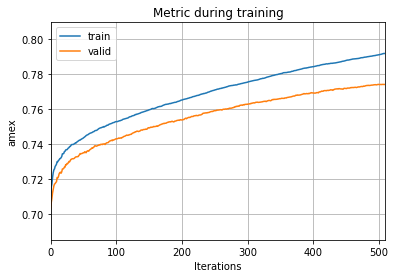

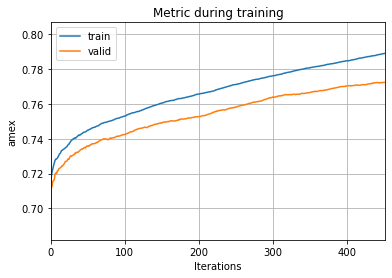

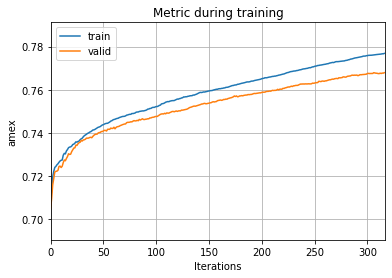

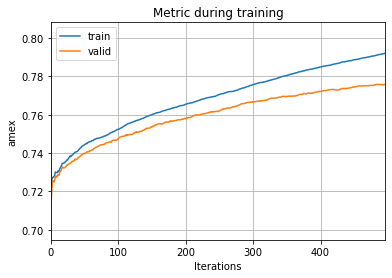

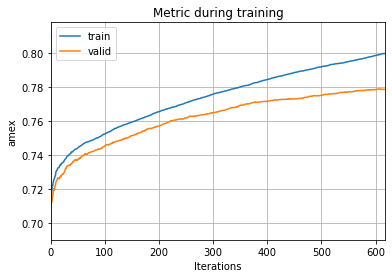

In [34]:
lgb_params = {"learning_rate": 0.01,
              'num_leaves': 127,
              'min_child_samples': 2400}

with open(f'{EXP_MODEL}/selected_features.txt', 'rb') as rf:
    features = pickle.load(rf)
models = fit_lgbm(train[features], train[Config.target], params=lgb_params)
# models = [joblib.load(f'{EXP_MODEL}/lgbm_fold{i}.pkl') for i in range(Config.n_splits)]
pred = inference_lgbm(models, test[features])

## Plot importance

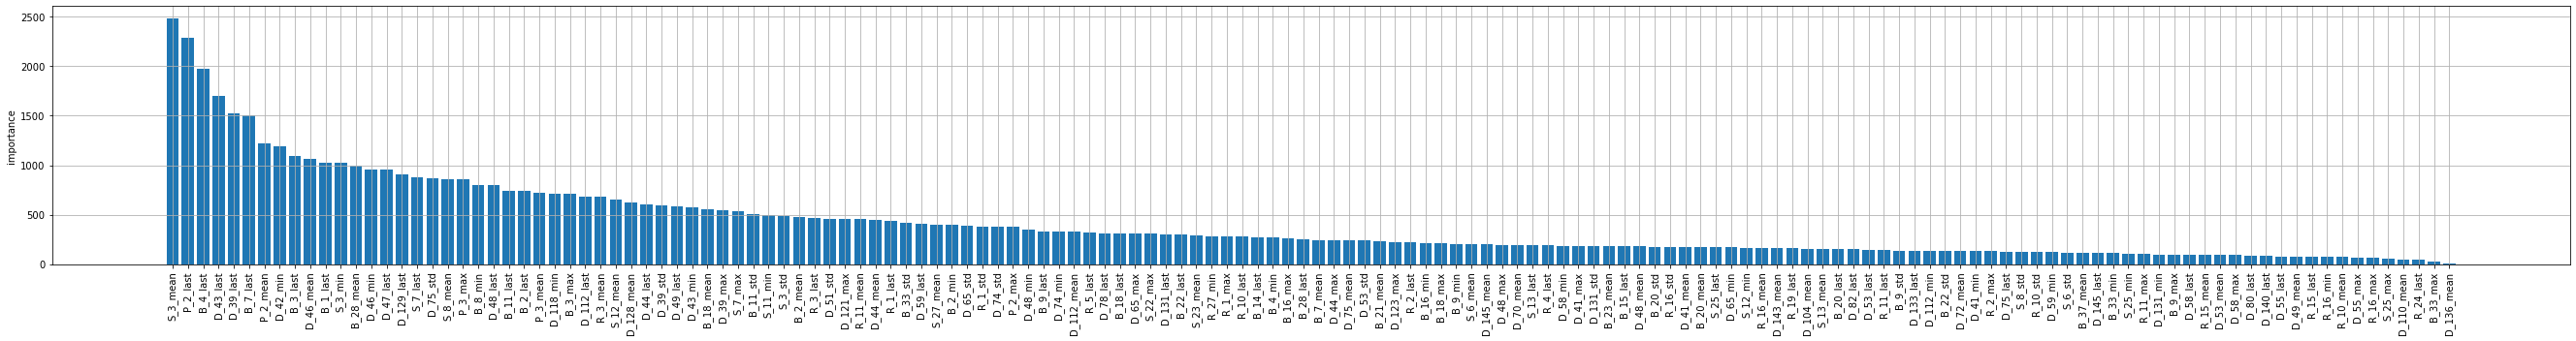

In [35]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=selected_features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(selected_features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.savefig(f'{EXP_FIG}/importance.png')

plot_importances(models)

## Submission

In [36]:
sub = pd.DataFrame({'customer_ID': test.index,
                    'prediction': pred})
sub.to_csv(f'{EXP_PREDS}/submission.csv', index=False)